In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from nn.linearsymplectic import *
from nn.nonlinearsymplectic import *

In [45]:
# Generate training data

l=50
domain = np.linspace(-l/2, l/2, 1000)
xi_0 = -l/4
denom = np.sqrt(1-0.2**2)
kink = lambda xi: 4 * np.arctan(np.exp((xi - xi_0)/denom))
ddt_kink = lambda xi: -4 * .2/denom * np.exp((xi - xi_0) / denom) / (1 + np.exp((xi - xi_0) / denom)**2)

q = ddt_kink(domain)
p = kink(domain)

x = np.stack([q, p], axis=1)

print(x.shape)

f = lambda x: np.stack([
    x[:,0] + 0.01*np.sin(x[:,1]),
    x[:,1]
], axis=1)

y = f(x)

(1000, 2)


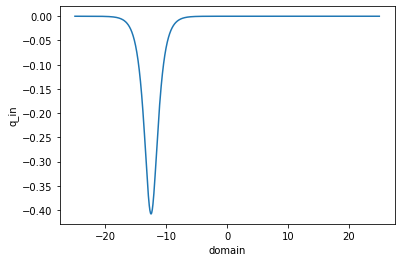

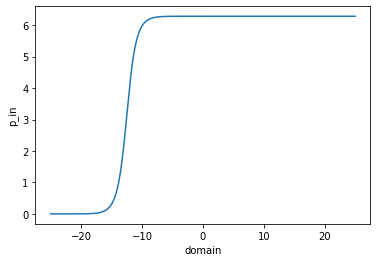

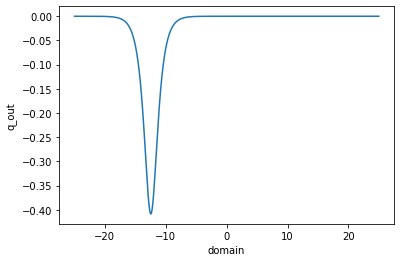

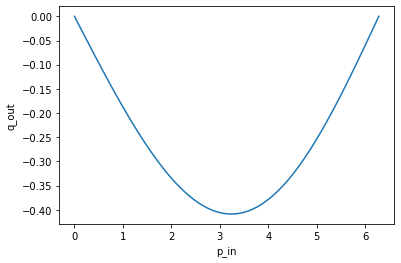

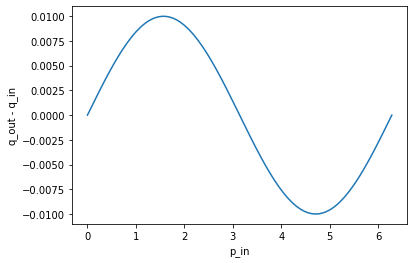

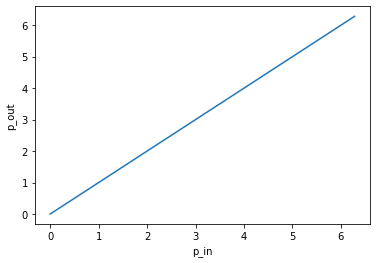

In [46]:
fig, ax = plt.subplots()
ax.plot(domain, x[:,0])
ax.set(xlabel='domain', ylabel='q_in')
plt.show()

fig, ax = plt.subplots()
ax.plot(domain, x[:,1])
ax.set(xlabel='domain', ylabel='p_in')
plt.show()

fig, ax = plt.subplots()
ax.plot(domain, y[:,0])
ax.set(xlabel='domain', ylabel='q_out')
plt.show()

fig, ax = plt.subplots()
ax.plot(x[:,1], y[:,0])
ax.set(xlabel='p_in', ylabel='q_out')
plt.show()

fig, ax = plt.subplots()
ax.plot(x[:,1], y[:,0]-x[:,0])
ax.set(xlabel='p_in', ylabel='q_out - q_in')
plt.show()

fig, ax = plt.subplots()
ax.plot(x[:,1], y[:,1])
ax.set(xlabel='p_in', ylabel='p_out')
plt.show()


In [47]:
def train(model, epochs = 10000):
    x_ = torch.tensor(x, requires_grad=True, dtype=torch.float32)
    y_ = torch.tensor(y, dtype=torch.float32)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    losses = []

    model.train()
    for epoch in range(epochs):
        if (epoch % 1000) == 0:
            print('training step: %d/%d' % (epoch, epochs))

        y1 = model(x_)
        loss = criterion(y1, y_)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.train(mode=False)

    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Number of learnable parameters: ', n_parameters)
    
    # Plot losses
    fig, ax = plt.subplots()
    ax.plot(np.array(losses))
    ax.set_yscale('log')
    plt.show()

def visualize(model):
    x_ = torch.tensor(x, requires_grad=True, dtype=torch.float32)
    y_ = model(x_)
    y_np = y_.detach().numpy()

    fig, ax = plt.subplots()
    ax.plot(x[:,1], y_np[:,0])
    ax.set(xlabel='p_in', ylabel='q_out')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(x[:,1], y_np[:,0]-x[:,0])
    ax.set(xlabel='p_in', ylabel='q_out - q_in')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(x[:,1], y_np[:,1])
    ax.set(xlabel='p_in', ylabel='p_out')
    plt.show()

    q0 = np.zeros(1000)
    p0 = np.linspace(0, 2*np.pi, 1000)
    x0 = np.stack([q0, p0], axis=1)
    x0_ = torch.tensor(x0, dtype=torch.float32)
    y0_ = model(x0_)

    fig, ax = plt.subplots()
    ax.plot(x0[:,1], y0_[:,0].detach())
    plt.show()

# Fully connected network

training step: 0/10000
training step: 1000/10000
training step: 2000/10000
training step: 3000/10000
training step: 4000/10000
training step: 5000/10000
training step: 6000/10000
training step: 7000/10000
training step: 8000/10000
training step: 9000/10000
Number of learnable parameters:  502


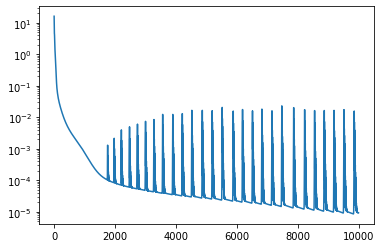

In [17]:
fnn = torch.nn.Sequential(
    torch.nn.Linear(2,100),
    torch.nn.Sigmoid(),
    torch.nn.Linear(100,2)
)

train(fnn)

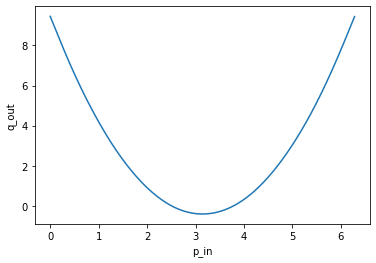

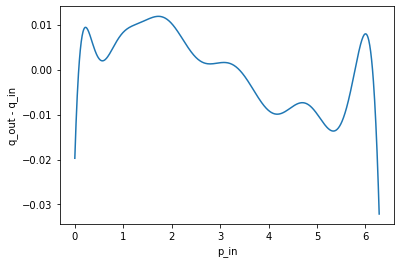

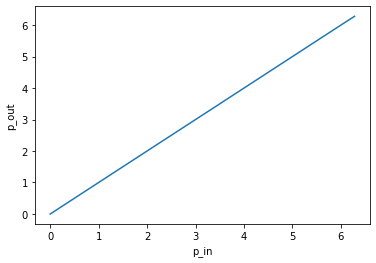

In [18]:
visualize(fnn)

# Fully connected network with batch normalization

training step: 0/10000
training step: 1000/10000
training step: 2000/10000
training step: 3000/10000
training step: 4000/10000
training step: 5000/10000
training step: 6000/10000
training step: 7000/10000
training step: 8000/10000
training step: 9000/10000
Number of learnable parameters:  702


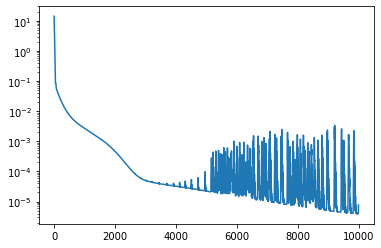

In [19]:
fnn_normalized = torch.nn.Sequential(
    torch.nn.Linear(2,100),
    torch.nn.BatchNorm1d(100),
    torch.nn.Sigmoid(),
    torch.nn.Linear(100,2)
)

train(fnn_normalized)



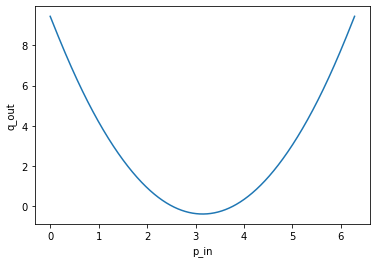

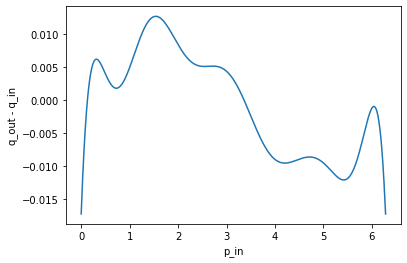

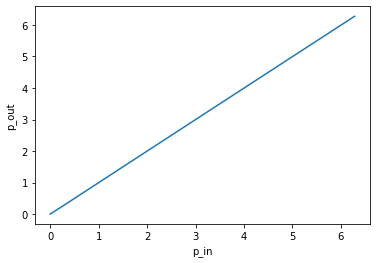

In [20]:
visualize(fnn_normalized)

# LA-SympNet

training step: 0/10000
training step: 1000/10000
training step: 2000/10000
training step: 3000/10000
training step: 4000/10000
training step: 5000/10000
training step: 6000/10000
training step: 7000/10000
training step: 8000/10000
training step: 9000/10000
Number of learnable parameters:  41


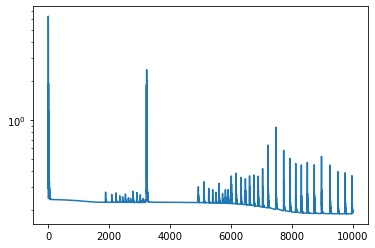

In [9]:
activation_fn = torch.sigmoid
dim = 2
la_sympnet = torch.nn.Sequential(
    LinearSymplectic(4, dim, bias=True),
    LowerNonlinearSymplectic(dim, bias=False, activation_fn=activation_fn),
    LinearSymplectic(4, dim, bias=True),
    UpperNonlinearSymplectic(dim, bias=False, activation_fn=activation_fn),
    LinearSymplectic(4, dim, bias=True),
    LowerNonlinearSymplectic(dim, bias=False, activation_fn=activation_fn),
    LinearSymplectic(4, dim, bias=True),
    UpperNonlinearSymplectic(dim, bias=False, activation_fn=activation_fn),
    LinearSymplectic(4, dim, bias=True),
    LowerNonlinearSymplectic(dim, bias=False, activation_fn=activation_fn),
    LinearSymplectic(4, dim, bias=True)
)

train(la_sympnet)

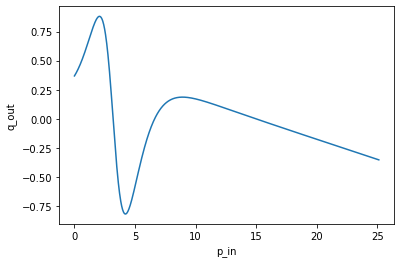

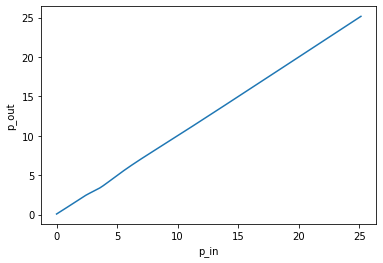

In [10]:
visualize(la_sympnet)

# LA-SympNet with similar amount of learnable parameters

training step: 0/10000
training step: 1000/10000
training step: 2000/10000
training step: 3000/10000
training step: 4000/10000
training step: 5000/10000
training step: 6000/10000
training step: 7000/10000
training step: 8000/10000
training step: 9000/10000
Number of learnable parameters:  300


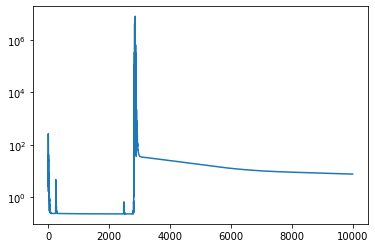

In [20]:
import itertools

activation_fn = torch.sigmoid
dim = 2
la_sympnet_large = torch.nn.Sequential(
    *itertools.chain.from_iterable([
        [
            LinearSymplectic(4, dim, bias=True),
            LowerNonlinearSymplectic(dim, bias=False, activation_fn=activation_fn),
            LinearSymplectic(4, dim, bias=True),
            UpperNonlinearSymplectic(dim, bias=False, activation_fn=activation_fn),
            LinearSymplectic(4, dim, bias=True)
        ] for i in range(0,15)
    ])
)

train(la_sympnet_large)

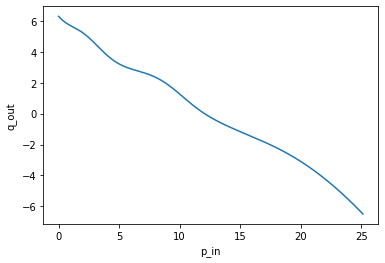

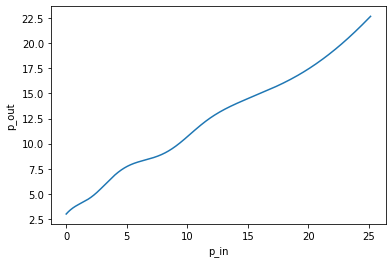

In [21]:
visualize(la_sympnet_large)

# G-SympNet

training step: 0/10000
training step: 1000/10000
training step: 2000/10000
training step: 3000/10000
training step: 4000/10000
training step: 5000/10000
training step: 6000/10000
training step: 7000/10000
training step: 8000/10000
training step: 9000/10000
Number of learnable parameters:  300


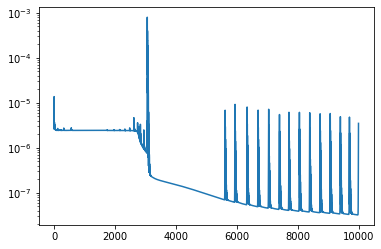

In [48]:
activation_fn = torch.sigmoid
dim = 2

g_sympnet = UpperGradientModule(dim, n=100, bias=False, activation_fn=activation_fn)

train(g_sympnet)

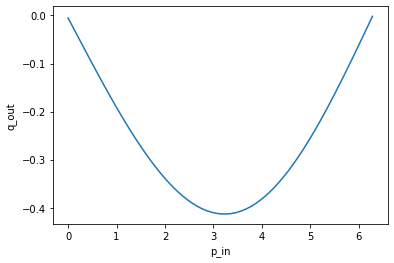

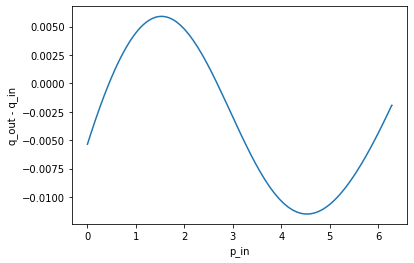

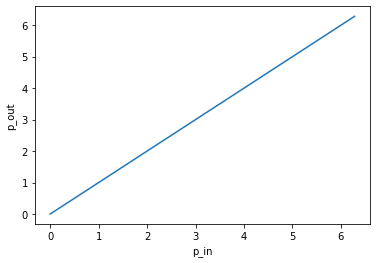

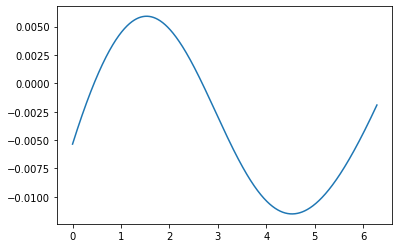

In [49]:
visualize(g_sympnet)

# Normalized G-SympNet

training step: 0/10000
training step: 1000/10000
training step: 2000/10000
training step: 3000/10000
training step: 4000/10000
training step: 5000/10000
training step: 6000/10000
training step: 7000/10000
training step: 8000/10000
training step: 9000/10000
Number of learnable parameters:  500


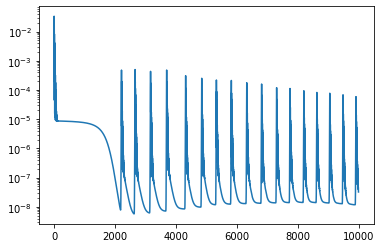

In [21]:
activation_fn = torch.sigmoid
dim = 2

g_sympnet_norm = NormalizedUpperGradientModule(dim, n=100, bias=False, activation_fn=activation_fn)

train(g_sympnet_norm)

In [11]:
visualize(g_sympnet_norm)

NameError: name 'g_sympnet_norm' is not defined

# Conv 1d Gradient Layer

training step: 0/10000
training step: 1000/10000
training step: 2000/10000
training step: 3000/10000
training step: 4000/10000
training step: 5000/10000
training step: 6000/10000
training step: 7000/10000
training step: 8000/10000
training step: 9000/10000
Number of learnable parameters:  300


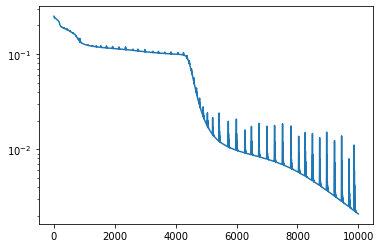

In [10]:
activation_fn = torch.sigmoid
dim = 2

g_conv1d = UpperConv1dGradientModule(dim, n=100, bias=False, activation_fn=activation_fn)

train(g_conv1d)

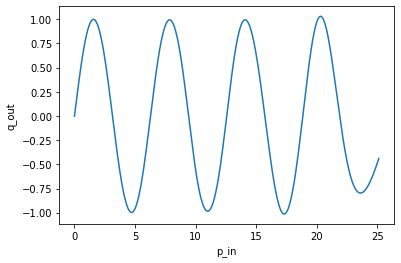

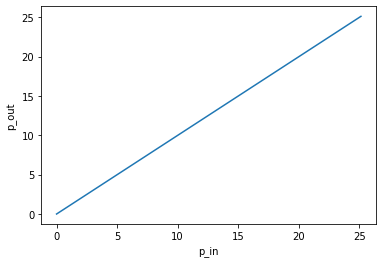

In [11]:
visualize(g_conv1d)

# Normalized Conv 1d Gradient Layer

training step: 0/10000
training step: 1000/10000
training step: 2000/10000
training step: 3000/10000
training step: 4000/10000
training step: 5000/10000
training step: 6000/10000
training step: 7000/10000
training step: 8000/10000
training step: 9000/10000
Number of learnable parameters:  500


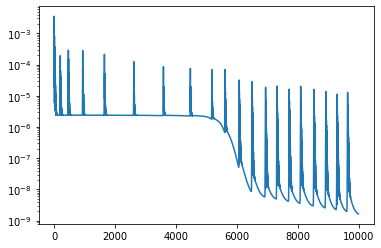

In [50]:
activation_fn = torch.sigmoid
dim = 2

g_norm_conv1d = NormalizedUpperConv1dGradientModule(dim, n=100, bias=False, activation_fn=activation_fn)

train(g_norm_conv1d)

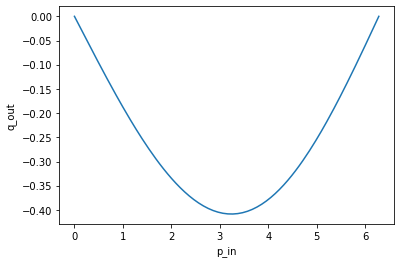

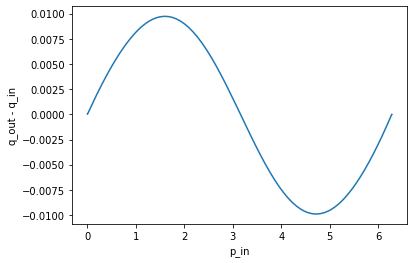

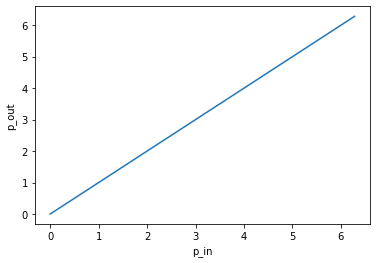

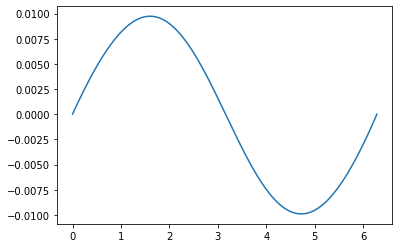

In [52]:
visualize(g_norm_conv1d)

# ResNet like 

In [26]:
activation_fn = torch.sigmoid
dim = 2

resnet_like = torch.nn.Sequential(
    NormalizedUpperConv1dGradientModule(dim, n=8, bias=False, activation_fn=activation_fn),
    NormalizedUpperConv1dGradientModule(dim, n=8, bias=False, activation_fn=activation_fn),
    NormalizedUpperConv1dGradientModule(dim, n=8, bias=False, activation_fn=activation_fn),
    NormalizedUpperConv1dGradientModule(dim, n=8, bias=False, activation_fn=activation_fn),
    NormalizedUpperConv1dGradientModule(dim, n=8, bias=False, activation_fn=activation_fn)
)

train(resnet_like)

training step: 0/10000
training step: 1000/10000
training step: 2000/10000


KeyboardInterrupt: 

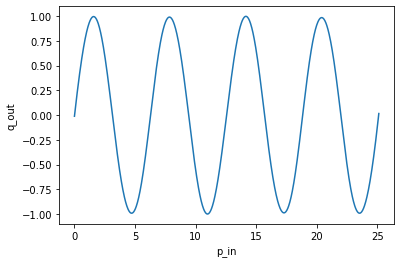

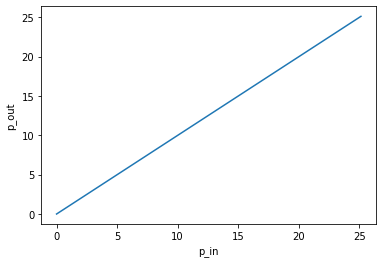

In [7]:
visualize(resnet_like)